# Práctica 1

## Importaciones

In [39]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

## Inicio de sesión en Spark

In [41]:
# Inicio de la sesión de Spark.
spark = SparkSession.builder \
    .appName("MarathonRegression") \
    .getOrCreate()

ConnectionRefusedError: [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión

## Visualización inicial de los datos

### Carga del dataset

In [ ]:
# Cargar el dataset.
df = spark.read.csv("run_ww_2020_d.csv", header=True, inferSchema=True)

### Muestra de las cinco primeras filas y del esquema

In [13]:
# Mostrar las cinco primeras filas.
df.show(5, truncate=False)

# Mostrar esquema de columnas.
df.printSchema()

+---+----------+-------+--------+------------------+------+---------+--------------+-----------------------+
|_c0|datetime  |athlete|distance|duration          |gender|age_group|country       |major                  |
+---+----------+-------+--------+------------------+------+---------+--------------+-----------------------+
|0  |2020-01-01|0      |0.0     |0.0               |F     |18 - 34  |United States |CHICAGO 2019           |
|1  |2020-01-01|1      |5.72    |31.633333333333333|M     |35 - 54  |Germany       |BERLIN 2016            |
|2  |2020-01-01|2      |0.0     |0.0               |M     |35 - 54  |United Kingdom|LONDON 2018,LONDON 2019|
|3  |2020-01-01|3      |0.0     |0.0               |M     |18 - 34  |United Kingdom|LONDON 2017            |
|4  |2020-01-01|4      |8.07    |38.61666666666667 |M     |35 - 54  |United States |BOSTON 2017            |
+---+----------+-------+--------+------------------+------+---------+--------------+-----------------------+
only showing top 5 

### Muestra de filas y variables y principales estadísticas del dataset

In [14]:
# Número de filas y variables.
print(f"Filas: {df.count()}, Variables: {len(df.columns)}")

# Estadísticas descriptivas de variables numéricas.
df.describe(['distance', 'duration']).show()

# Distribución por género y grupo de edad.
df.groupBy("gender").count().show()
df.groupBy("age_group").count().show()

Filas: 13326792, Variables: 9
+-------+-----------------+------------------+
|summary|         distance|          duration|
+-------+-----------------+------------------+
|  count|         13326792|          13326792|
|   mean|3.864718473881684| 21.39197543564929|
| stddev|6.661547347662435| 39.27358918572176|
|    min|              0.0|               0.0|
|    max|           347.95|2299.9666666666667|
+-------+-----------------+------------------+

+------+--------+
|gender|   count|
+------+--------+
|     F| 3253374|
|     M|10073418|
+------+--------+

+---------+-------+
|age_group|  count|
+---------+-------+
|     55 +| 940254|
|  35 - 54|7905966|
|  18 - 34|4480572|
+---------+-------+



## Preparación del dataset

### Creación de la variable "season" a partir de la datetime

In [15]:
df = df.withColumn("month", month("datetime"))

df = df.withColumn(
    "season",
    when((df.month >= 3) & (df.month <= 5), "spring")
    .when((df.month >= 6) & (df.month <= 8), "summer")
    .when((df.month >= 9) & (df.month <= 11), "autumn")
    .otherwise("winter"))

### Filtrado de filas

Como tenemos un gran número de filas, vamos a filtrar. Primero, nos quedamos solo con los registros que no estén vacíos, es decir, aquellos cuya duración y distancia sea mayor a 0.

In [16]:
# Filtrado de filas.
df_filtered = df.filter((df.duration > 0) & (df.distance > 0))

# Comprobar tamaño.
print(f"Filas tras filtrar: {df_filtered.count()}")

Filas tras filtrar: 4581764


Como seguimos teniendo gran número de filas, volvemos a filtrar. Ahora vamos a filtrar por número de atletas. Inicialmente tenemos 36.7k atletas. Vamos a probar con cuantos nos quedamos con el número de filas más adecuado.

In [17]:
# Filtrar atletas con ID < 5000.
df_filtered_5000 = df_filtered.filter(df_filtered.athlete < 5000)
print(f"Filas con athlete < 5000: {df_filtered_5000.count()}")

# Filtrar atletas con ID < 8000.
df_filtered_8000 = df_filtered.filter(df_filtered.athlete < 8000)
print(f"Filas con athlete < 8000: {df_filtered_8000.count()}")

# Filtrar atletas con ID < 10000.
df_filtered_10000 = df_filtered.filter(df_filtered.athlete < 10000)
print(f"Filas con athlete < 10000: {df_filtered_10000.count()}")

# Filtrar atletas con ID < 15000.
df_final = df_filtered.filter(df_filtered.athlete < 15000)
print(f"Filas con athlete < 15000: {df_final.count()}")

# Filtrar atletas con ID < 20000.
df_filtered_20000 = df_filtered.filter(df_filtered.athlete < 20000)
print(f"Filas con athlete < 20000: {df_filtered_20000.count()}")

Filas con athlete < 5000: 629313
Filas con athlete < 8000: 1001656
Filas con athlete < 10000: 1255519
Filas con athlete < 15000: 1878765
Filas con athlete < 20000: 2483092


Nos quedamos con 15000 atletas (1878765 filas), ya que creemos que es el valor más adecuado para lograr un equilibrio entre cantidad para un correcto aprendizaje y velocidad de procesamiento. 

### Muestra de filas y variables y principales estadísticas del dataset filtrado

In [18]:
# Número de filas y variables.
print(f"Filas: {df_final.count()}, Variables: {len(df_final.columns)}")

# Estadísticas descriptivas de variables numéricas.
df_final.describe(['distance', 'duration']).show()

# Distribución por género y grupo de edad.
df_final.groupBy("gender").count().show()
df_final.groupBy("age_group").count().show()

Filas: 1878765, Variables: 11
+-------+------------------+--------------------+
|summary|          distance|            duration|
+-------+------------------+--------------------+
|  count|           1878765|             1878765|
|   mean|11.337875722616882|    62.6373797680926|
| stddev|  6.85062966629291|  44.442787948108126|
|    min|              0.01|0.016666666666666666|
|    max|            263.37|              2202.0|
+-------+------------------+--------------------+

+------+-------+
|gender|  count|
+------+-------+
|     F| 466030|
|     M|1412735|
+------+-------+

+---------+-------+
|age_group|  count|
+---------+-------+
|     55 +| 138997|
|  35 - 54|1123696|
|  18 - 34| 616072|
+---------+-------+



### Seleccionamos solo las columnas relevantes

In [19]:
# Seleccionamos las columnas que no son datetime o major.
df_final = df_final.select("athlete", "distance", "duration", "gender", "age_group", "country", "season")

In [28]:
df_final = df_final.dropna(subset=["athlete", "distance", "duration", "gender", "age_group", "country", "season"])

## Preparación de los datos para el entrenamiento

### Convertimos los datos categóricos en vectores one-hot.

In [29]:
# Convertimos las columnas de tipo categórico en índices numéricos. 
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
age_indexer = StringIndexer(inputCol="age_group", outputCol="age_index")
country_indexer = StringIndexer(inputCol="country", outputCol="country_index")
season_indexer = StringIndexer(inputCol="season", outputCol="season_index")

# Convertimos los índices numéricos del paso anterior en vectores one-hot.
encoder = OneHotEncoder(inputCols=["gender_index", "age_index", "country_index", "season_index"],
                        outputCols=["gender_vec", "age_vec", "country_vec", "season_vec"])

### Combinamos las columnas numéricas en un solo vector.

In [30]:
# Creamos un vector features que combine todas las variables numéricas.
assembler = VectorAssembler(inputCols=["distance", "gender_vec", "age_vec", "country_vec", "season_vec"],
                            outputCol="features")

### Creamos un pipeline para aplicar todas las transformaciones

In [31]:
# Creamos el Pipeline con todas las etapas.
pipeline = Pipeline(stages=[gender_indexer, age_indexer, country_indexer, season_indexer, encoder, assembler])

# Ajustamos el pipeline y transformamos los datos.
df_prepared = pipeline.fit(df_final).transform(df_final)

In [37]:
print(df_prepared.select("features").show(5, truncate=False))

+-------------------------------------------+
|features                                   |
+-------------------------------------------+
|(113,[0,1,2,6,112],[5.72,1.0,1.0,1.0,1.0]) |
|(113,[0,1,2,4,112],[8.07,1.0,1.0,1.0,1.0]) |
|(113,[0,2,4,112],[10.09,1.0,1.0,1.0])      |
|(113,[0,1,4,112],[9.82,1.0,1.0,1.0])       |
|(113,[0,1,2,5,112],[10.05,1.0,1.0,1.0,1.0])|
+-------------------------------------------+
only showing top 5 rows

None


### División de los datos en entrenamiento y test

In [33]:
# Obtenemos los atletas.
athletes = df_final.select("athlete").distinct()

# Asignamos aleatoriamente el 80% de atletas a train y el 20% a test.
train_athletes, test_athletes = athletes.randomSplit([0.8, 0.2], seed=42)

# Filtramos filas según atletas asignados.
train_df = df_prepared.join(train_athletes, on="athlete", how="inner")
test_df = df_prepared.join(test_athletes, on="athlete", how="inner")

# Mostramos el número de filas en train y test.
print(f"Train: {train_df.count()} filas, Test: {test_df.count()} filas")

Train: 1501617 filas, Test: 367591 filas


## Creación de los modelos

### Modelo Regresión Lineal

In [34]:
from pyspark.sql.functions import col

# Definir la columna objetivo
df_model = df_prepared.withColumnRenamed("duration", "label")

# Comprobamos
df_model.select("features", "label").show(5, truncate=False)


+-------------------------------------------+------------------+
|features                                   |label             |
+-------------------------------------------+------------------+
|(113,[0,1,2,6,112],[5.72,1.0,1.0,1.0,1.0]) |31.633333333333333|
|(113,[0,1,2,4,112],[8.07,1.0,1.0,1.0,1.0]) |38.61666666666667 |
|(113,[0,2,4,112],[10.09,1.0,1.0,1.0])      |43.56666666666667 |
|(113,[0,1,4,112],[9.82,1.0,1.0,1.0])       |50.53333333333333 |
|(113,[0,1,2,5,112],[10.05,1.0,1.0,1.0,1.0])|59.05             |
+-------------------------------------------+------------------+
only showing top 5 rows


In [35]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Asegurarnos de que la columna 'label' existe
train_df = train_df.withColumnRenamed("duration", "label")
test_df = test_df.withColumnRenamed("duration", "label")

# Crear el modelo de regresión lineal
lr = LinearRegression(featuresCol="features", labelCol="label")

# Entrenar el modelo
lr_model = lr.fit(train_df)

# Generar predicciones sobre el conjunto de test
lr_predictions = lr_model.transform(test_df)

# Evaluador para regresión
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

# Calcular métricas
rmse = evaluator.setMetricName("rmse").evaluate(lr_predictions)
r2 = evaluator.setMetricName("r2").evaluate(lr_predictions)

# Mostrar resultados
print("=== Linear Regression ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# (Opcional) Mostrar algunas predicciones reales vs. predichas
lr_predictions.select("athlete", "label", "prediction").show(10, truncate=False)


=== Linear Regression ===
RMSE: 20.11
R²: 0.7978
+-------+------------------+------------------+
|athlete|label             |prediction        |
+-------+------------------+------------------+
|833    |64.73333333333333 |82.2859988280031  |
|1591   |45.11666666666667 |51.30823525596566 |
|4900   |28.983333333333334|26.574000893079244|
|5518   |57.45             |70.54505450154033 |
|7754   |31.416666666666668|30.559500330691186|
|7982   |75.0              |78.00097410056401 |
|10623  |107.0             |128.93111309736972|
|11141  |48.25             |51.24856607857893 |
|833    |43.516666666666666|48.93665302461811 |
|1829   |26.566666666666666|18.062433998574065|
+-------+------------------+------------------+
only showing top 10 rows


In [36]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Crear el modelo de árbol de decisión
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label")

# Entrenar el modelo
dt_model = dt.fit(train_df)

# Generar predicciones sobre el conjunto de test
dt_predictions = dt_model.transform(test_df)

# Evaluar el modelo
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

rmse = evaluator.setMetricName("rmse").evaluate(dt_predictions)
r2 = evaluator.setMetricName("r2").evaluate(dt_predictions)

# Mostrar resultados
print("=== Decision Tree Regressor ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Mostrar algunas predicciones
dt_predictions.select("athlete", "label", "prediction").show(10, truncate=False)

=== Decision Tree Regressor ===
RMSE: 23.44
R²: 0.7252
+-------+------------------+------------------+
|athlete|label             |prediction        |
+-------+------------------+------------------+
|833    |64.73333333333333 |80.03623657102844 |
|1591   |45.11666666666667 |53.087971272349435|
|4900   |28.983333333333334|30.322122707567665|
|5518   |57.45             |71.77434374695046 |
|7754   |31.416666666666668|30.322122707567665|
|7982   |75.0              |71.77434374695046 |
|10623  |107.0             |114.70354577117796|
|11141  |48.25             |49.25349959494697 |
|833    |43.516666666666666|49.25349959494697 |
|1829   |26.566666666666666|30.322122707567665|
+-------+------------------+------------------+
only showing top 10 rows


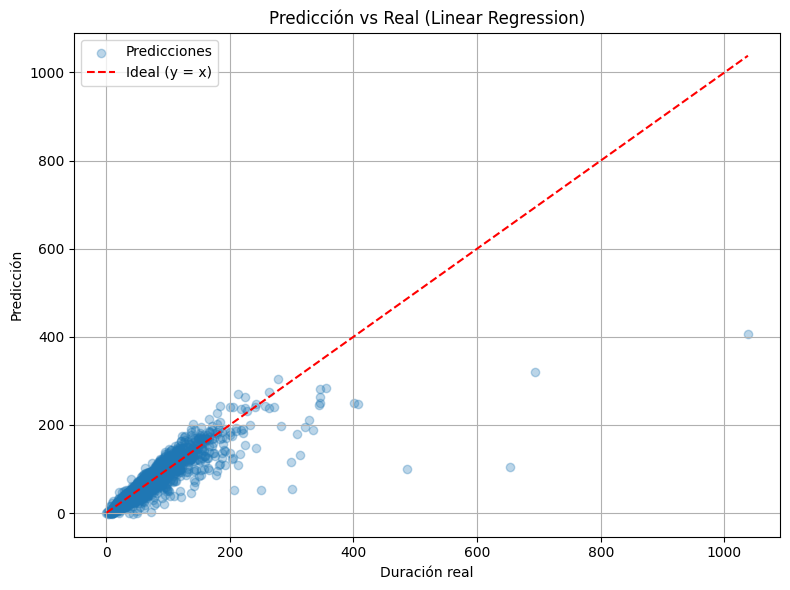

In [34]:
import matplotlib.pyplot as plt
# Muestra pequeña para visualización (ej. 1% del total)
sample_pd = lr_predictions.select("label", "prediction").sample(False, 0.01, seed=42).toPandas()

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(sample_pd["label"], sample_pd["prediction"], alpha=0.3, label="Predicciones")
plt.plot([sample_pd["label"].min(), sample_pd["label"].max()],
         [sample_pd["label"].min(), sample_pd["label"].max()],
         'r--', label="Ideal (y = x)")

plt.xlabel("Duración real")
plt.ylabel("Predicción")
plt.title("Predicción vs Real (Linear Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Crear el modelo de Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=50, maxDepth=6, seed=42)

# Entrenar el modelo
rf_model = rf.fit(train_df)

# Generar predicciones sobre el conjunto de test
rf_predictions = rf_model.transform(test_df)

# Evaluador
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

# Calcular métricas
rmse = evaluator.setMetricName("rmse").evaluate(rf_predictions)
r2 = evaluator.setMetricName("r2").evaluate(rf_predictions)

# Mostrar resultados
print("=== Random Forest Regressor ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Mostrar algunas predicciones
rf_predictions.select("athlete", "label", "prediction").show(10, truncate=False)

=== Random Forest Regressor ===
RMSE: 28.49
R²: 0.5939
+-------+------------------+------------------+
|athlete|label             |prediction        |
+-------+------------------+------------------+
|833    |64.73333333333333 |67.50826670146267 |
|1591   |45.11666666666667 |54.00452454925491 |
|4900   |28.983333333333334|37.70285324375012 |
|5518   |57.45             |64.97723753080116 |
|7754   |31.416666666666668|44.181535910000775|
|7982   |75.0              |66.59167888998354 |
|10623  |107.0             |128.23309110601286|
|11141  |48.25             |47.85685258620212 |
|833    |43.516666666666666|47.515974224040235|
|1829   |26.566666666666666|39.24376617500065 |
+-------+------------------+------------------+
only showing top 10 rows

